# 1. Exploring the dataset

In [1]:
from src import *
import json

/Users/michaelc.c.h/opt/miniconda3/envs/brain2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Description

We re-format emotion files and fmri files to combine then and make it easier for access at once.

GOAL: Reformat emotion-fmri related files and quick exploration of data.

## Table of Contents
- [Emotion item data](#emotion)
    - Reformatting
    - Exploring
- [fMRI data](#fmri)
    - Reformatting
    - Exploring

<a class="anchor" id="emotion"></a>
### Emotion item data

In [2]:
emo_path = "./data/emoFiles/emo/"

We simplify the datasets so as to make it easier in the future to load. Be careful that the formats for any of our processed emotion csv would be the following way.

#### Reformatting

We reformat "Emo_BIDS" folder's file that we later got, the emotion timeseries are comparable across emotions and movies.

In [4]:
emo_df2 = format_bids('./data/emoFiles/EmoBIDS/')

# #Uncomment to save the record to csv
# emo_df2.to_csv('./data/emotion_compileBIDS.csv', index=False)

#### Exploring

In [8]:
emo_df2 = pd.read_csv('./data/emoFiles/emotion_compileBIDS.csv')

In the long run we need to understand in a movie:
- where events are
- which feeling is happening the most often in general we don't have absolute values so timesereis from metrics should be discrete differences as well 
- how long an event is happening for us to be able to catch it in terms of change 

We partially look into it in the following plots.

1. We look in this case how present each emotions are in a movie. We compute the average score it receives during the movie and compare it with the other emotions.

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


categories = np.array(['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Regard','Anxiety', \
             'Satisfaction','Pride','Surprise','Love','Sad'])

fig         = make_subplots(rows=2, cols=3)
partial_mov = emo_df2.filename.unique()
dispersion  = {}
for idx,mov in enumerate(partial_mov):

    row,col = idx//3, idx%3
    r1      = []
    for s in categories:
        tmp = np.array(list(emo_df2[(emo_df2.filename == mov) & (emo_df2.item == s)]['score']))
        r1.append(np.percentile(tmp, 95))

    dispersion[mov] = r1
    fig.add_trace(go.Scatterpolar(
          r     = r1,
          theta = categories,
          fill  = 'toself',
          name  = mov.split('_')[1].split('.')[0][:-2]
    ))

fig.update_layout(
  polar = dict(
    radialaxis = dict(
      visible  = True,
      # range=[0, 5]
    )),
  showlegend   = True
)
fig.show()

2. Let's as well visualize the timeseries for few items in a movie

Text(0.5, 1.0, 'Scores over time for W_Chatter13.csv')

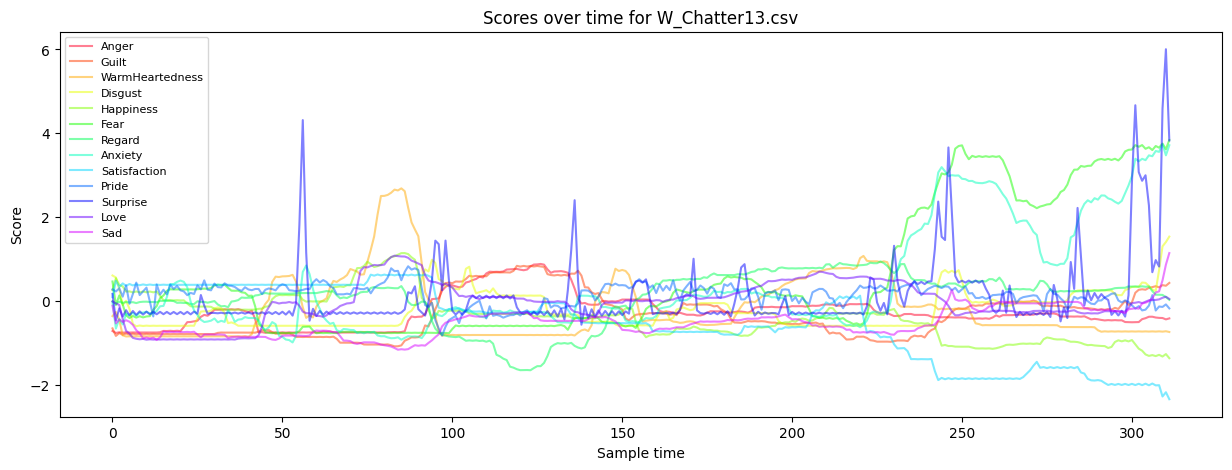

In [10]:
# NOTE: that the temporal coherence was conserved when we reformatted the files
moviename = 'W_Chatter13.csv'

select    = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Regard','Anxiety', \
             'Satisfaction','Pride','Surprise','Love','Sad']

NUM_COLORS = len(select)
cm         = plt.get_cmap('gist_rainbow')

fig,ax     = plt.subplots(1,1, figsize=(15,5))

ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for s in select:
        cur_df = emo_df2[(emo_df2['filename'] == moviename) & 
                (emo_df2['item'] == s)]
        ax.plot(np.arange(len(cur_df)), cur_df['score'], label=s, alpha=0.5)
ax.legend(prop={'size':8})
ax.set_xlabel('Sample time')
ax.set_ylabel('Score')
ax.set_title('Scores over time for {}'.format(moviename))

3. We look at matching frames of emotions and BOLD timecourse

In [22]:
mri_df   = pd.read_csv('./data/fmri414_compiled/AfterTheRain_compiled414.csv')
filename = 'TC_414_sub-S11_AfterTheRain.csv'
tmp,cur  = df_to_timeseries(mri_df, filename)

cur_df   = emo_df2[(emo_df2['filename'] == 'W_AfterTheRain13.csv') & 
                (emo_df2['item'] == 'Sad')]
emo_time = cur_df['score']
emo_time = np.array(list(emo_time))

startidx = np.where(emo_time > 1.5)[0][0]
endidx   = np.where(emo_time > 1.5)[0][-1]

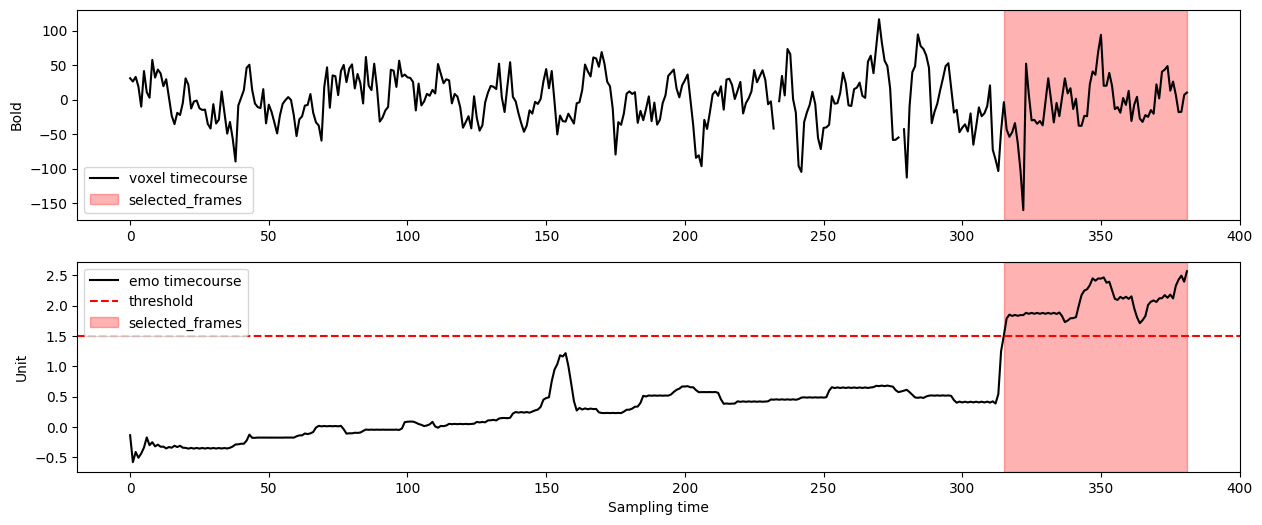

In [68]:
fmri_time = tmp[:,0][:len(emo_time)]

fig, ax = plt.subplots(2,1,figsize=(15,6)) 
ax[0].plot(fmri_time, label='voxel timecourse', color='k')
ax[0].axvspan(startidx, endidx, alpha=0.3, color='red', label='selected_frames')
ax[0].legend(loc=0)
ax[0].set_ylabel('Bold')



ax[1].plot(emo_time, label='emo timecourse', color='k')
ax[1].axhline(y = 1.5, color = 'r', linestyle = '--', label='threshold')
ax[1].axvspan(startidx, endidx, alpha=0.3, color='red', label='selected_frames')
ax[1].set_ylabel('Unit')
ax[1].set_xlabel('Sampling time')
ax[1].legend(loc=0)



<a class="anchor" id="fmri"></a>
### fMRI data

#### Reformatting

1. Cortical Only

We first split up with cortical only timecourses (since we may need to process only cortical parcels, so excluding subcortical)

In [82]:
list_mri_df, names = format_timecourse_cortical("./data/fMRIFiles/TRFiles/", 
                                                './data/labels/7N_networks_centroids.csv')

# #Uncomment to save the record to csv
# for idx,n in enumerate(names):
#     list_mri_df[idx].to_csv('./data/fmri400_compiled/'+n+'_compiled.csv', index=False)

100%|██████████| 15/15 [12:28<00:00, 49.91s/it]


2. Combine Subcortical and Cortical

We pick up the compiled versions with only Cortical and generate a compiled version with subcortical areas included as well

In [ ]:
list_mri_df, L = combine_timecourse_subcortical('./data/fmri400_compiled/', 
                               './data/labels/TC_sub14_labels.csv')

for k in range(len(list_mri_df)):
    list_mri_df[k].to_csv('./data/fmri414_compiled/{}414.csv'.format(L[k][:-4]), index=False)

quick verification that the values are indeed the same after formatting

In [10]:
# # verify correct formatting by comparing the timecourse loading I implemented versus direct load from original file
# # we load a random file and check that indeed the timecourses were kept almost the same (up to very very small change in float value)
# tmp = np.loadtxt("./data/fMRIFiles/TRFiles/TC_400_sub-S22_ses-1_TheSecretNumber.csv", delimiter=',')

# movie_name414   = 'TheSecretNumber_compiled414.csv'
# mri_df414mov    = pd.read_csv('./data/fmri414_compiled/' + movie_name414)

# movie_series414, _ = df_to_timeseries(mri_df414mov, "TC_414_sub-S22_TheSecretNumber.csv")

# tmp[np.isnan(tmp)] = 0
# movie_series414[np.isnan(movie_series414)] = 0

# np.sum(movie_series414[:,:400] - tmp)

#### Exploring

1. Plot a few timeseries for some arbitrary voxels

In [11]:
mri_df = pd.read_csv('./data/fmri400_compiled/Rest_compiled.csv')

Text(0, 0.5, 'Bold')

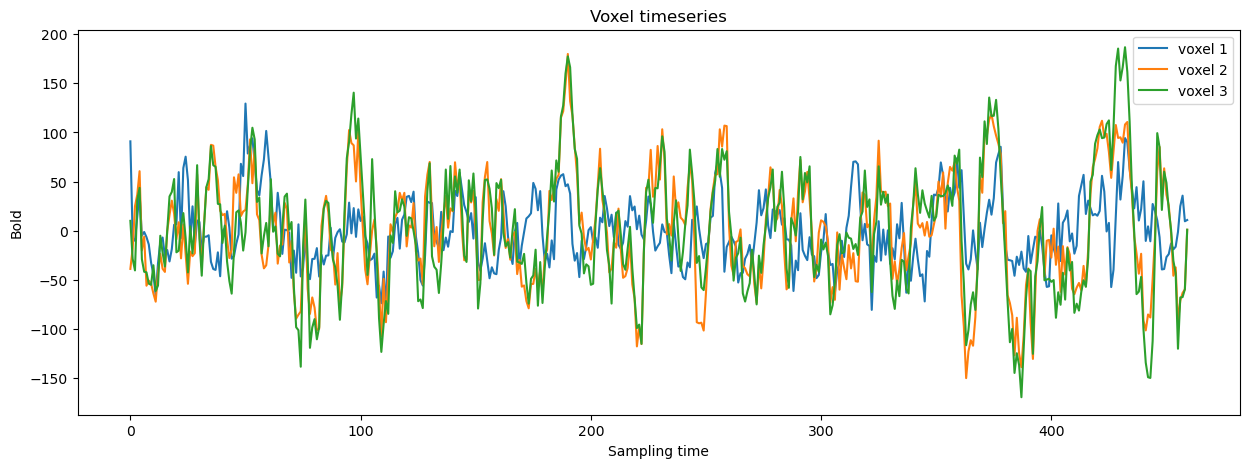

In [12]:
filename = 'TC_400_sub-S09_ses-1_Rest.csv'
tmp,cur  = df_to_timeseries(mri_df, filename)

plt.figure(figsize=(15,5))
plt.plot(tmp[:,0], label='voxel 1')
plt.plot(tmp[:,10], label='voxel 2')
plt.plot(tmp[:,20], label='voxel 3')
plt.legend()
plt.title('Voxel timeseries')
plt.xlabel('Sampling time')
plt.ylabel('Bold')

2. A preprocessing that is done later on (we visualize such preprocessing here) on timecourses. We detrend.

In [ ]:
from scipy.ndimage import gaussian_filter

sigma = 50
cutoff_freq = 1/(2*TR*sigma)
newsigma = 1
newcutoff_freq = 1/(2*TR*newsigma)
# sig_gauss = 1/np.sqrt(8*np.log(2)) * 1/(TR*cutoff_freq)

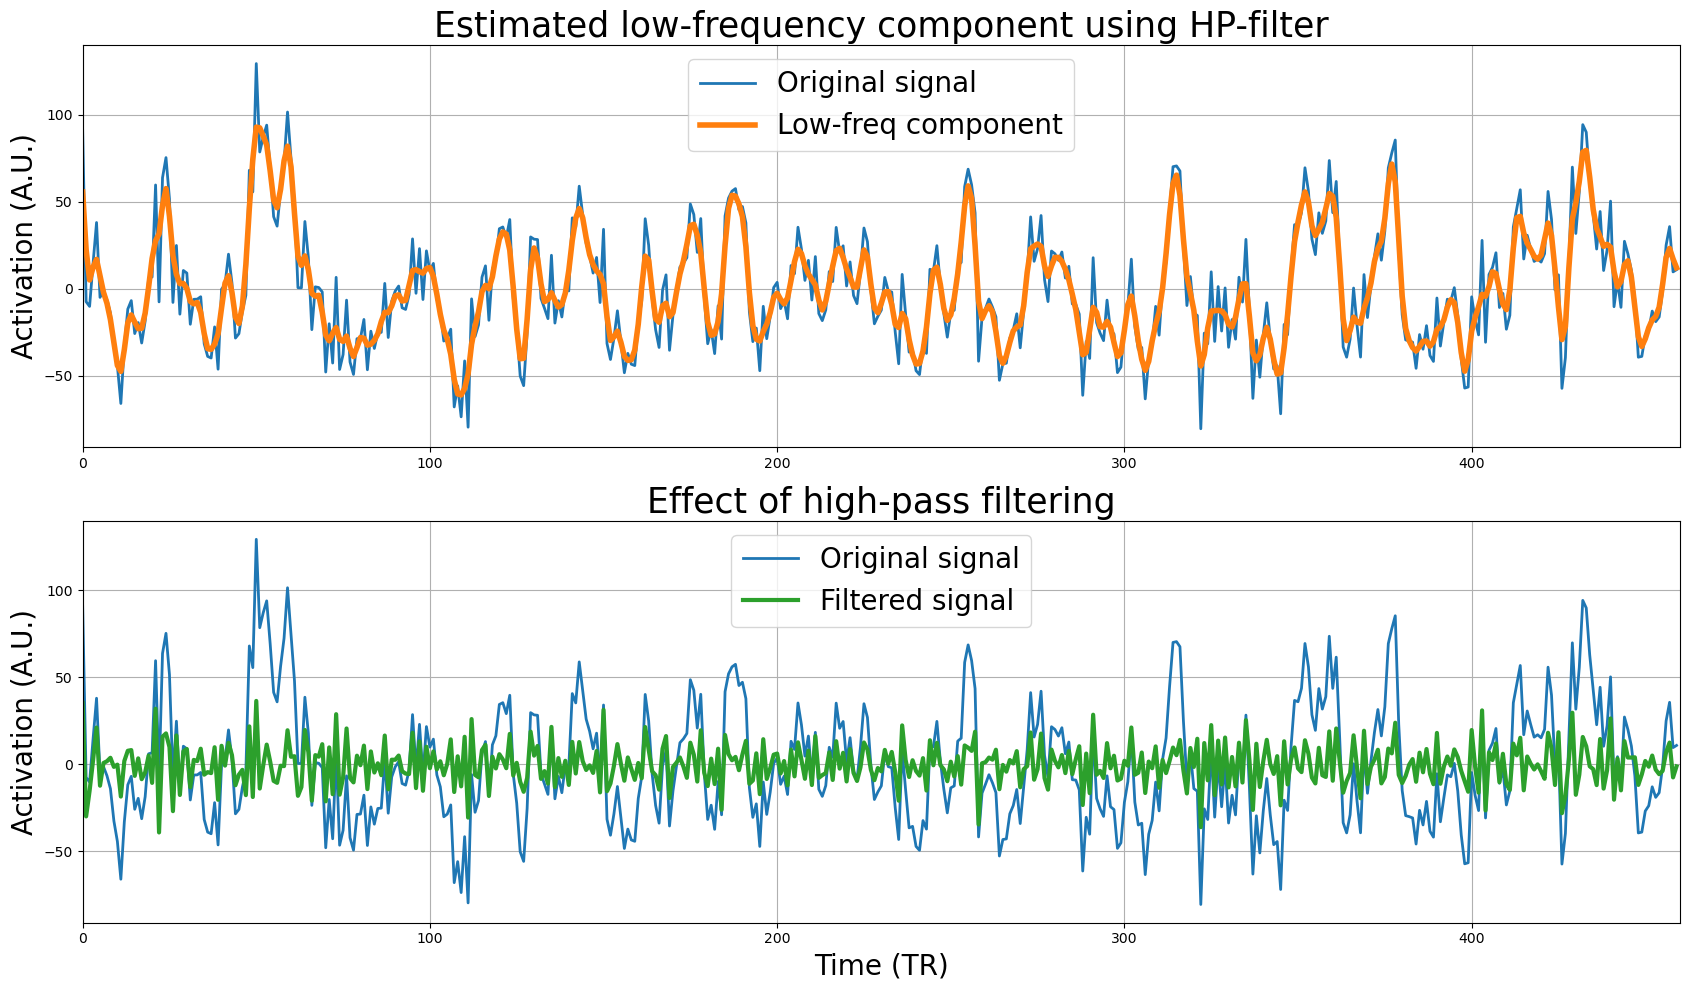

In [43]:
# https://lukas-snoek.com/NI-edu/fMRI-introduction/week_4/temporal_preprocessing.html
sig = tmp[:,0]
filt = gaussian_filter(sig, newsigma)

plt.figure(figsize=(17, 10))

plt.subplot(2, 1, 1)
plt.plot(sig, lw=2)
plt.plot(filt, lw=4)
plt.xlim(0, sig.size)
plt.legend(['Original signal', 'Low-freq component'], fontsize=20)
plt.title("Estimated low-frequency component using HP-filter", fontsize=25)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.grid()

# IMPORTANT: subtract filter from signal
filt_sig = sig - filt

plt.subplot(2, 1, 2)
plt.plot(sig, lw=2)
plt.plot(filt_sig, lw=3, c='tab:green')
plt.xlim(0, sig.size)
plt.legend(['Original signal', 'Filtered signal'], fontsize=20)
plt.title("Effect of high-pass filtering", fontsize=25)
plt.xlabel("Time (TR)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.grid()

plt.tight_layout()
plt.show()